In [70]:
import pandas
import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz
import pystan
import random
import pylab
from helper_functions import *
from sklearn.neighbors import KernelDensity
from scipy.spatial import cKDTree as KDTree
from scipy.stats import multivariate_normal
from scipy.stats import norm, kstest, probplot, shapiro
from fastkde import fastKDE
from entropy_estimators import continuous



In [71]:
# whether to recompile the stan program
DO_COMPILE = False

# stan program path
stan_path = 'multi_feature.stan'


def build_model(path, pkl_file=None, do_compile=True):
    if do_compile:
        sm = pystan.StanModel(file=path)
        if pkl_file is not None:
            with open(pkl_file, 'wb') as f:
                pickle.dump(sm, f)

    # if the program hasn't been complied, check that the file already exists
    else: 
        if os.path.isfile(pkl_file):
            sm = pickle.load(open(pkl_file, 'rb'))
        else:
            raise FileNotFoundError
    return sm


sm = build_model(path = stan_path, pkl_file='model.pkl', do_compile=DO_COMPILE)


Model parameters

In [76]:
# mu
mu_mean = 1
mu_sd = 0.5

# sd
sigma_alpha = 1
sigma_beta = 1

# noise SD
noise = 0.25

# environmental EIG
EIG_env = 1

Input and output data

In [77]:
LONG_DATA = False

if LONG_DATA:
    # Simulate complex data
    num_samples = 100
    num_exemplars = 3
    num_features = 1
    exemplar_idx = np.random.choice(list(range(1, num_exemplars+1)), num_samples, p=[24/50,25/50,1/50]) 
    exemplar_means = np.random.randint(5, size = (num_exemplars, num_features))
    sig = np.identity(num_features);
    sim_data = [np.random.multivariate_normal(exemplar_means[idx-1], sig) for idx in exemplar_idx] 



# handcrafted example
else:
    num_samples = 10
    num_exemplars = 2
    num_features = 1
    exemplar_idx = [1,1,1,1,1,2,2,2,2,2]
    exemplar_means = np.array([1,5])
    sig = np.identity(num_features)*noise;
    sim_data = [np.random.normal(exemplar_means[idx-1], sig) for idx in exemplar_idx] 
    sim_data = np.array(sim_data).squeeze(axis=2)


# number of posterior predictive samples
num_posterior_samples = 1

# initialize data dict:
data = {"mu_mean": mu_mean , "mu_sd": mu_sd, "sigma_alpha": sigma_alpha, "sigma_beta": sigma_beta, "noise": noise, # parameters  
"F": num_features, "M": num_samples, "K": num_exemplars, "z": np.transpose(sim_data), "exemplar_idx": exemplar_idx, # data info
"P": num_posterior_samples} # posterior samples

sim_data

array([[0.70412812],
       [1.137733  ],
       [1.17956879],
       [1.45381423],
       [0.94651214],
       [5.19254632],
       [4.93423225],
       [5.00580273],
       [5.04867929],
       [5.02474078]])

Run model


Gradient evaluation took 1.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  6000 / 20000 [ 30%]  (Warmup)
Iteration:  8000 / 20000 [ 40%]  (Warmup)
Iteration: 10000 / 20000 [ 50%]  (Warmup)
Iteration: 10001 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.160638 seconds (Warm-up)
               0.189846 seconds (Sampling)
               0.350484 seconds (Total)

Inference for Stan model: anon_model_86392c07d15713ee8974f66df8be9313.
1 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

 

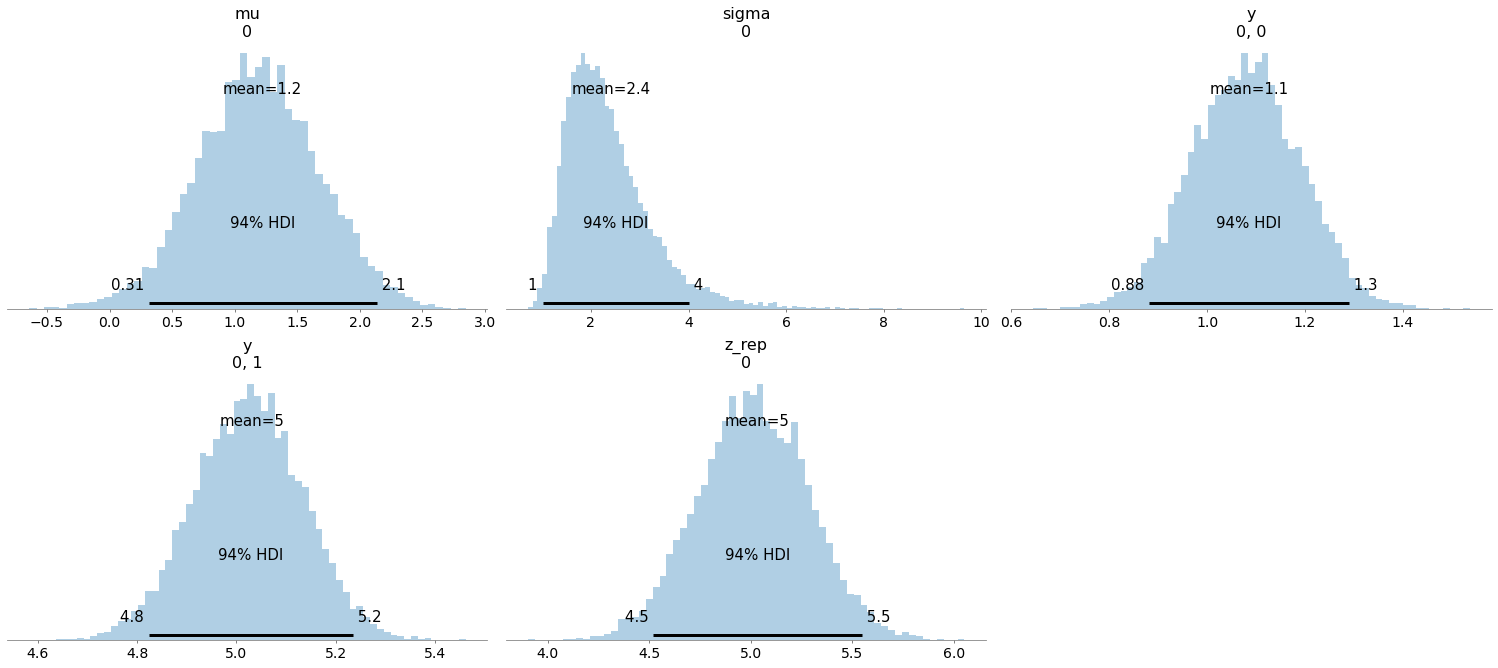

In [78]:
fit = sm.sampling(data=data, iter=20000, chains=1)

model_fit = arviz.from_pystan(fit)

arviz.plot_posterior(model_fit, kind = 'hist')
print(fit)

plt.show()

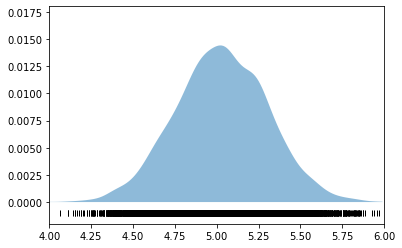

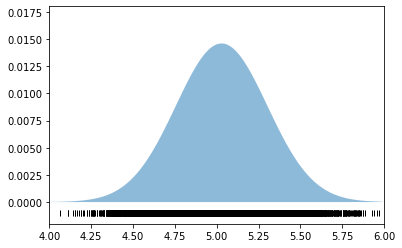

/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [80]:
fit.extract().keys()

np.shape(fit['z_rep'])

grid = np.arange(4, 6, step = 0.01)
density = np.empty((np.shape(grid)[0], num_features))
density_gaussian = np.empty((np.shape(grid)[0], num_features))

for i in np.arange(0, np.shape(fit['z_rep'])[1]):

    # fit kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(fit['z_rep'][:,i][:,None])
    density_unnormalized = np.exp(kde.score_samples(grid[:,None]))
    density[:,i] = density_unnormalized / np.sum(density_unnormalized)

     # fit gaussian
    mean = np.mean(fit['z_rep'][:,i][:,None])
    sd = np.std(fit['z_rep'][:,i][:,None])
    density_gaussian[:,i] = norm.pdf(grid, loc = mean, scale = sd)


plt.axis([4,6, -0.002, 0.018])
plt.fill_between(grid, density[:,0], alpha=0.5)
plt.plot(fit['z_rep'][:,0], np.full_like(fit['z_rep'][:,0], -0.001), '|k', markeredgewidth=1)
plt.show()

plt.axis([4,6, -0.002, 0.018])
plt.fill_between(grid, density_gaussian[:,0]/np.sum(density_gaussian[:,0]), alpha=0.5)
plt.plot(fit['z_rep'][:,0], np.full_like(fit['z_rep'][:,0], -0.001), '|k', markeredgewidth=1)
plt.show()

# sanity check whether var(fit['y']) = var(fit['z_rep']) + noise**2 (as in stan program)

# this should be close to 0
sd**2 - np.var(fit['y'].squeeze(1)[:,-1]) - noise**2


# multiply posterior predictives with KL



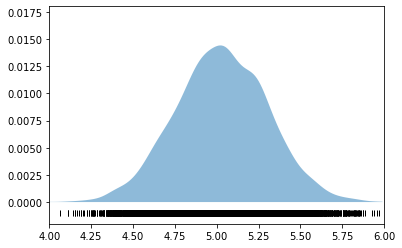

In [ ]:
fit.extract().keys()

np.shape(fit['z_rep'])

grid = np.arange(4, 6, step = 0.01)
density = np.empty((np.shape(grid)[0], num_features))
density_gaussian = np.empty((np.shape(grid)[0], num_features))

for i in np.arange(0, np.shape(fit['z_rep'])[1]):

    # fit kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(fit['z_rep'][:,i][:,None])
    density_unnormalized = np.exp(kde.score_samples(grid[:,None]))
    density[:,i] = density_unnormalized / np.sum(density_unnormalized)

     # fit gaussian
    mean = np.mean(fit['z_rep'][:,i][:,None])
    sd = np.std(fit['z_rep'][:,i][:,None])
    density_gaussian[:,i] = norm.pdf(grid, loc = mean, scale = sd)


plt.axis([4,6, -0.002, 0.018])
plt.fill_between(grid, density[:,0], alpha=0.5)
plt.plot(fit['z_rep'][:,0], np.full_like(fit['z_rep'][:,0], -0.001), '|k', markeredgewidth=1)
plt.show()

plt.axis([4,6, -0.002, 0.018])
plt.fill_between(grid, density_gaussian[:,0]/np.sum(density_gaussian[:,0]), alpha=0.5)
plt.plot(fit['z_rep'][:,0], np.full_like(fit['z_rep'][:,0], -0.001), '|k', markeredgewidth=1)
plt.show()

shapiro(fit['z_rep'][:,0][:,None])


# sanity check whether var(fit['y']) = var(fit['z_rep']) + noise**2 (as in stan program)
sd**2 - np.var(fit['y'].squeeze(1)[:,1]) - noise**2



# check whether i can get posterior predictive by:
# -getting densities on a feature level, i.e. only for z_rep0
    # option 1: kernel density estimation 
    # option 2: knn --> https://math.stackexchange.com/questions/4028633/which-is-the-algorithm-for-knn-density-estimator
# - get posterior predictive of hypothetical observation by multiplying individual densities of each feature (since features are independent)
# This is likely to work better than KDE on the sampled posteriors because we only need to do a couple of 1-dimensional KDEs in this case, 
# one per feature (still need to choose bandwith though)

# multiply posterior predictives with KL

# sanity test:

# get posterior predictive in a model by sampling from a gaussian with mean X and SD Y and do KDE
# check how close mean and SD are to X and Y respectively

